In [1]:
import io
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression 
from keras.utils import to_categorical
from nltk.corpus import stopwords

###########################################################################
#generate training/test data
########################################################################### 
positive_file1 = io.open("Happy_clean.txt",'r',encoding="latin-1")
positive_file2 = io.open("Blessed_clean.txt",'r',encoding="latin-1")
positive_file3 = io.open("Proud_clean.txt",'r',encoding="latin-1")

negative_file1 = io.open("FML_clean.txt",'r',encoding="latin-1")
negative_file2 = io.open("Sad_clean.txt",'r',encoding="latin-1")
negative_file3 = io.open("Ugh_clean.txt",'r',encoding="latin-1")

training_samples = 30000
bragging_tweets = []
bitching_tweets = []


for line in positive_file1:
    bragging_tweets.append(line.strip("\n"))
for line in positive_file2:
    bragging_tweets.append(line.strip("\n"))
for line in positive_file3:
    bragging_tweets.append(line.strip("\n"))
for line in negative_file1:
    bitching_tweets.append(line.strip("\n"))
for line in negative_file2:
    bitching_tweets.append(line.strip("\n"))
for line in negative_file3:
    bitching_tweets.append(line.strip("\n"))


np.random.seed(42)
bragging_tweets = np.array(bragging_tweets)
bitching_tweets = np.array(bitching_tweets)

np.random.shuffle(bragging_tweets)
np.random.shuffle(bitching_tweets)


data = []

for i in range(150000):
    data.append([bragging_tweets[i],0])
    data.append([bitching_tweets[i],1])


      


np.random.shuffle(data)


tweets_train = np.array(data[:250000])
tweets_test = np.array(data[250000:])



X_train = tweets_train[:,0]
Y_train = tweets_train[:,1]
X_test = tweets_test[:,0]
Y_test = tweets_test[:,1]





print("Success")

Using TensorFlow backend.


Success


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 50
training_samples = 200000
max_words = 10000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
word_index = tokenizer.word_index
print ('Found %s unique tokens.' % len(word_index))


Found 246173 unique tokens.


In [3]:
data = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(Y_train)
print ("shape of the data tensor:", data.shape)
print ("shape of the label tensor: ", labels.shape)


shape of the data tensor: (250000, 50)
shape of the label tensor:  (250000,)


In [5]:
# splits data into a training set and a validation set
# indices = np.arange(data.shape[0])
# np.random.shuffle(indices)
# data = data[indices]
# labels = labels[indices]
import os

x_train = data[:]
y_train = labels[:]
# x_val = data[training_samples:]
# y_val = labels[training_samples:]

glove_dir = 'glove.twitter.27B'
embeddings_index = {}
#your maxlen and you .txt files must correspond
f = open(os.path.join(glove_dir, 'glove.twitter.27B.50d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs=np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.'%len(embeddings_index))


Found 1193514 word vectors.


In [6]:

embedding_dim = maxlen
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if (i < max_words):
        embedding_vector= embeddings_index.get(word)
        if (embedding_vector is not None):
            embedding_matrix[i] = embedding_vector

In [7]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))

model.add(SimpleRNN(32,activation = 'tanh'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            500000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2656      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 502,689
Trainable params: 502,689
Non-trainable params: 0
_________________________________________________________________


In [9]:
import keras.optimizers
sgd = keras.optimizers.SGD(lr=0.0001*400)
model.compile(optimizer = sgd,
             loss = 'binary_crossentropy',
             metrics = ['acc'])

history = model.fit(x_train, y_train, epochs = 4, batch_size= 32, validation_split = 0.10 )
model.save_weights('pre-trained_glove_twitter_model.h5')

Train on 225000 samples, validate on 25000 samples
Epoch 1/4
225000/225000 [==============================] - 293s 1ms/step - loss: 0.4987 - acc: 0.7518 - val_loss: 0.5034 - val_acc: 0.7387
Epoch 2/4
225000/225000 [==============================] - 293s 1ms/step - loss: 0.4007 - acc: 0.8197 - val_loss: 0.3916 - val_acc: 0.8282
Epoch 3/4
225000/225000 [==============================] - 294s 1ms/step - loss: 0.3773 - acc: 0.8332 - val_loss: 0.4308 - val_acc: 0.7928
Epoch 4/4
225000/225000 [==============================] - 293s 1ms/step - loss: 0.3646 - acc: 0.8410 - val_loss: 0.3729 - val_acc: 0.8372


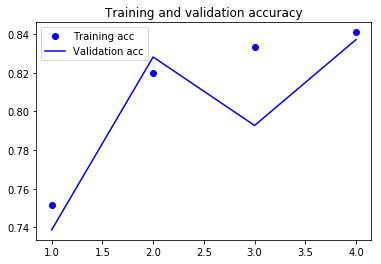

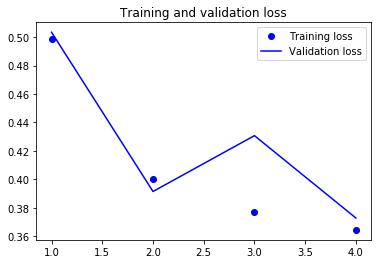

In [10]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
## These will be results on the test
sequences = tokenizer.texts_to_sequences(X_test)
x_test = pad_sequences(sequences, maxlen = maxlen)
y_test = np.asarray(Y_test)
model.load_weights('pre-trained_glove_twitter_model.h5')

from keras.utils import plot_model
plot_model(model, to_file='model.png')
model.evaluate(x_test, y_test)

50000/50000 [==============================] - 16s 311us/step


[0.37442105213642118, 0.83660000000000001]

In [15]:
def predict(pred):
    predictions = []
    for item in pred:
        if item[0]<=0.5: 
            predictions.append("Bragging")
        else:
            predictions.append("Bitching")
    return predictions

In [16]:

pred=model.predict(x_test)
#print(predictions)
#print(pred)
p=predict(pred)
#print(p)
for i in range(50):
    print("Predicted Class: "+str(p[i])+" Actual Class: "+str(Y_test[i])+"\n"+str(X_test[i]))

Predicted Class: Bitching Actual Class: 1
Redrafting sometimes means you have to turn entire pages of description into dialogue in order to make it flow better #timeconsuming
Predicted Class: Bragging Actual Class: 0
Awesome sculpture that will make you .Magical hands at work to make #art face and figures from plasters breathing real life into them.
Predicted Class: Bragging Actual Class: 0
#Teens #Porn #Filth Enter Free Chat with #Blondesexdolls -> lesbians-girls/blondesexdolls … #FreeWebChat
Predicted Class: Bitching Actual Class: 1
Spent two hours stuck in Deira traffic while looking for envelopes, copied data onto 50 USBs & now facilitating 2 photo-shoots at work.
Predicted Class: Bragging Actual Class: 0
Everything's Working Out Well Right Now. #LovingLife
Predicted Class: Bitching Actual Class: 1
Greaaat!!! 3rd day of summer and I've got the flu!!!
Predicted Class: Bragging Actual Class: 0
Let it snow... Let it snow... Let it snow... #snow #villa83 #doha #qatar #Christmas #NewYea

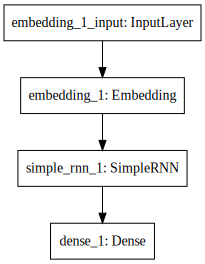

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))